# Mini-Project - Modified ResNet Model

Outline:

1.   Download, transform, and view the dataset
2.   Prepare dataloaders for training set and validation set
3.   Construct the model 
4.   Check device, move to GPU
5.   Train the model
6.   Test the model with single image
7.   Summary
8.   References


Techniques used to improve accuracy:
*   data normalization
*   random transformation/data augmentation
*   added weight decay
*   set limits for the gradient (gradient clipping)
*   added varying learning rate using a learning rate scheduler 

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

## Download, transform, and view the dataset

In [ ]:
# Download from S3
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
# Check the folders. The folder structure is one folder per class.
directory = './data/cifar10'

print(os.listdir(directory))
classes = os.listdir(directory + "/train")
print(classes)

In [ ]:
# Transforms the original images and load the images as torch tensors
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor


stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_ds = ImageFolder(directory+'/train', train_tfms)
valid_ds = ImageFolder(directory+'/test', valid_tfms)

In [ ]:
# 10 classes
print(train_ds.classes)

In [ ]:
# Check the images. Each images has 3 channels, with size 32x32.
img, label = train_ds[0]
print(img.shape, label)
img

In [ ]:
# Look at a single image in the training set, after the transformations
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
show_example(*train_ds[1])

## Prepare Dataloaders For Training Set And Validation Set

In [ ]:
# Create dataloaders

from torch.utils.data.dataloader import DataLoader

batch_size = 400

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [ ]:
# View the batch in grids, after denormalizing 
from torchvision.utils import make_grid

# denormalize the pixels
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images, nrow=20).permute(1, 2, 0))
        break

In [ ]:
show_batch(train_dl)

## Construct the model 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Define structure for training and validation processes for each epoch
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# setup individual resnet block
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


In [ ]:
# setup resnet architecture 
class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.classifier(out)
        return out


In [ ]:
# Check the architecture
model = ResNet(3, 10)
model

## Check device, move to GPU


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
# wrap dataloaders in DeviceDataLoader or using GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
to_device(model, device);

## Train the Model

In [ ]:
# Define the evaluation method
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Improvements
*   added weight decay
*   set limits for the gradient (gradient clipping)
*   added varying learning rate using a learning rate scheduler 



In [ ]:
# Define the problem-independent fit() function to drive the training
def fit(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # added weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # added learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # added gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']



In [ ]:
# Initial evaluation before training -> low accuracy
history = [evaluate(model, valid_dl)]
history

In [ ]:
# Train the model for 10/20/30 epochs
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [67]:
%%time
history += fit(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00103, train_loss: 1.4223, val_loss: 1.0460, val_acc: 0.6344
Epoch [1], last_lr: 0.00279, train_loss: 0.9893, val_loss: 1.2019, val_acc: 0.5922
Epoch [2], last_lr: 0.00519, train_loss: 0.8445, val_loss: 0.8977, val_acc: 0.6965
Epoch [3], last_lr: 0.00759, train_loss: 0.7730, val_loss: 1.1583, val_acc: 0.6243
Epoch [4], last_lr: 0.00936, train_loss: 0.6855, val_loss: 0.9288, val_acc: 0.7023
Epoch [5], last_lr: 0.01000, train_loss: 0.5909, val_loss: 0.5545, val_acc: 0.8084
Epoch [6], last_lr: 0.00987, train_loss: 0.5102, val_loss: 0.5194, val_acc: 0.8261
Epoch [7], last_lr: 0.00950, train_loss: 0.4670, val_loss: 0.5326, val_acc: 0.8208
Epoch [8], last_lr: 0.00891, train_loss: 0.4353, val_loss: 0.5192, val_acc: 0.8221
Epoch [9], last_lr: 0.00812, train_loss: 0.3958, val_loss: 0.6172, val_acc: 0.7939
Epoch [10], last_lr: 0.00717, train_loss: 0.3798, val_loss: 0.6214, val_acc: 0.7858
Epoch [11], last_lr: 0.00611, train_loss: 0.3425, val_loss: 0.4058, val_acc: 0.8622
Ep

In [68]:
# Plot the accuracy results
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

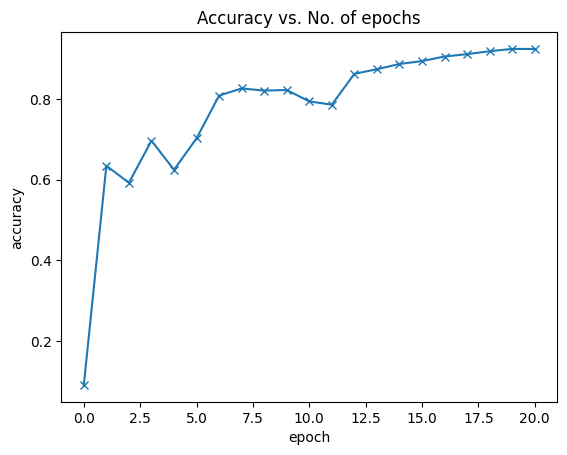

In [69]:
plot_accuracies(history)

In [70]:
# Check difference between training set and validation set to make sure there no overfitting
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

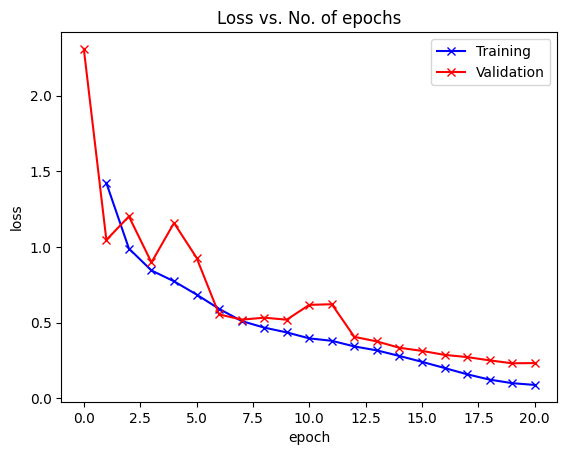

In [71]:
plot_losses(history)

In [72]:
#  Visualize how the learning rate changed over time
import numpy as np

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

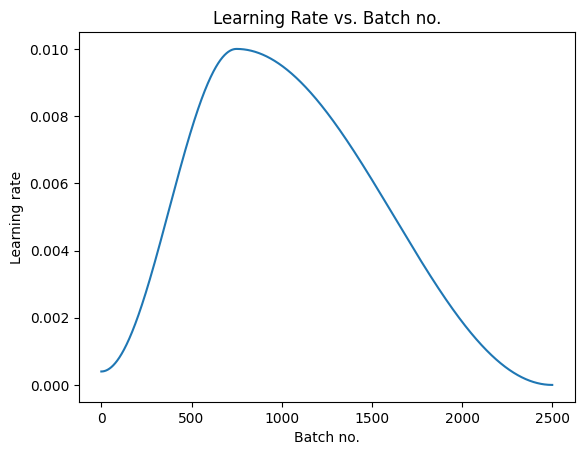

In [73]:
plot_lrs(history)

## Test the Model With Single Image

In [74]:
# helper function to show predicted class
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


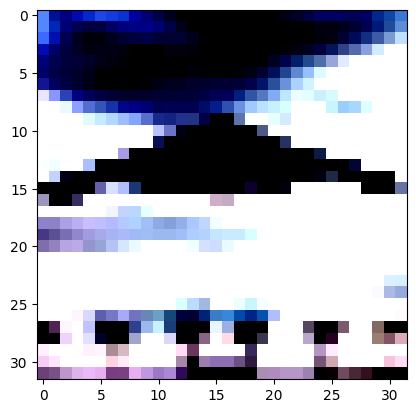

In [75]:
# show prediction for single image
img, label = valid_ds[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


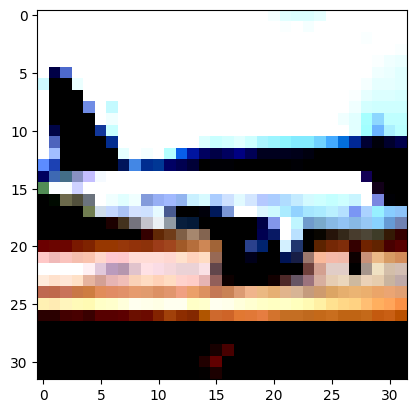

In [76]:
img, label = valid_ds[500]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: bird , Predicted: bird


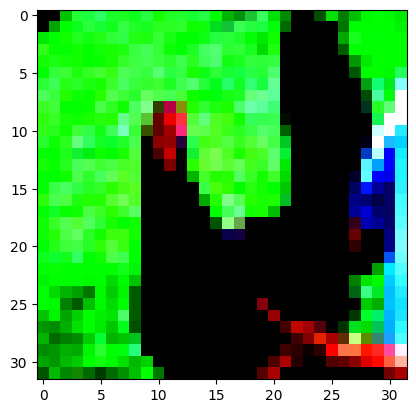

In [77]:
img, label = valid_ds[2000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

## Summary

In [78]:
from torchsummary import summary

summary(model,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

The final accuracy of the model reached 92.4 after 20 epochs and 92.7% after 30 epochs, with 1.85 million parameters.





## References


*   How to Train Your ResNet https://myrtle.ai/learn/how-to-train-your-resnet/ 
*   Classifying CIFAR10 images using ResNets https://jovian.com/aakashns/05b-cifar10-resnet 
*   CS-GY 6953 Demo Notes https://github.com/kvgarimella/dl-demos/blob/main/demo05-implement-resnet-visualize-loss-landscape.ipynb 
*   ResNets for CIFAR-10 https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0
